# Analyzing Cultural Diversity through Census Data of Language Spoken at Home

By Jordan Crawford-O'Banner and Alli Busa

By watching the news, one can assume that diversity is increasing rapidly in the United States. While the Census has praised the U.S. for becoming overall more racial and ethnically diverse, FOX newscaster Tucker Carlson has claimed that the movement of immigrants into the U.S. is not happening in "politicians' neighborhoods" and that the increasing number of racial and cultural groups from non-western countries in the U.S. is changing the culture in American towns to an unprecedented and unmanageable degree.

We wanted to take these two clashing statements and put them both to the test. Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? Are regions with high ratios of non-English speakers actually linguistically diverse or homogeneously consisting of a non-English speaking community? 

## Importing Necessary Packages and Setting Up Data Imports

Importing necessary packages.

In [1]:
%matplotlib inline

#Make outputs look nice
import warnings
warnings.filterwarnings('ignore')

#Packages for Calculating
import pandas as pd
import numpy as np
from thinkstats2 import Pmf, Cdf
import thinkstats2

#Packages for Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
import thinkplot
from IPython.display import display_html, HTML

The data that we will analyze for this project is the Census' datasets on language in the U.S., which is available to everyone for noncommercial use. The specific data we will use is the Census' processed responses to the questions,"Does this person speak a language other than English at home?" and "What is this language?". The Census is filled out by one family member for the whole household and the questions posed to the Census respondents are the questions in quotations above for the whole duration of our dataset. (see [About Census Language Use](https://www.census.gov/topics/population/language-use/about/historical.html)). Ideally, every household with a U.S. citizen should respond to the Census, because it is federal law to fill it out. We acknowledge however, that undocumented citizens, who probably would inform our language data, may not fill out the survey. Nonetheless, we trust the Census data to be valid, even if it is somewhat limited, because it is federally governed. </p>
We have three data sets from the Census. They contain a list of over 380 languages that Americans speak at home as well as the corresponding number of Americans who spoke each language in 2000, the 2006 to 2008 period and the 2009 to 2013 period. 
For each of these periods the data was processed into excel documents differently. For example, in the year 2000 data, the excel spreadsheets each correspond to a state and contain data on the state as a whole as well as its individual counties. These two different variables are given in the same column. On the other hand, in the 2009-2013 data, the counties data and states data are given in two separate excel files altogether. In the 2006-2008 data, there is no data set by counties. </br>
There were some responses to lesser known languages that were omitted due to a very few number of respondents. We account for this issue while organizing our data set below. 



##### Creating Functions and Lists Used for Parsing

In order to collect data from multiple Excel sheets more efficiently, we will create a list of state abbreviations and state names. This is important because the data that has been provided to us for 2006 and 2009 has separated the data for each state onto a different sheet within the excel file. We are creating two lists because some of our data's sheet names are state abbreviations and some are counties. 

In [2]:
#State abbreviations
#Taken from https://gist.github.com/JeffPaine/3083347
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT","DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

#State names
#Taken from https://gist.github.com/tleen/6299431
statesfull=['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut',
            "District of Columbia",'Delaware','Florida','Georgia',
            'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
            'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska',
            'Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota',
            'Ohio','Oklahoma','Oregon','Pennsylvania',
            'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont',
            'Virginia','Washington','West Virginia','Wisconsin','Wyoming']

Now we will create a function called createSeries, which will allow us to create a Pandas Series from multiple sheets within an Excel file. 

In [3]:
def createSeries(arrayNames, textfileName, index, Column, skiprows=[0,1,2]):
    """
    Makes a Series with specific language information from excel file. 
    It is used for organizing data on total English speakers and total non-English speakers.


    arrayNames - this will be either states or statesfull, depending on how Excel sheets are organized
    textfileName - the datafile
    index - either 0 for total English speakers or 1 for total non-English speakers
    Column - depending on the year, the column which contains the number of speakers is either given as "Number of speakers" or "Number of speakers1"
    skiprows - the number of rows before the data begins changes based on Excel file. For the 2006-2008 data, it is [0,1,2], for the 2009-2013 data, it is [0,1,2,3]

    """
    emptySeries = pd.Series()
    i=0
    for area in arrayNames:

        df = pd.read_excel(textfileName, area, skiprows=skiprows).dropna()

        #dictionary[area] = df.loc[dictionaryindex1:dictionaryindex1,Column]
        emptySeries.set_value(i,df.loc[index, Column])
        
        i+=1
    
    #Clean Data
    emptySeries.replace(['(X)', '--'], np.nan, inplace=True)
    emptySeries.replace(['(B)'],0, inplace=True)
    
    return emptySeries
    

Note that this function also cleans the data. 
There are some entries which do not have numerical values due to sampling error. For example, 'X' indicates that the question does not apply. 
We changed 'B' to 0, because those entries indicate that there were too few sample observations to compute an estimate, and we decided that 0 is more representative of that sampling error. We did not change entries labeled 'D', which represent data withheld to avoid disclosure, because the dropna function already treats it as NAN.

### Importing and Organizing Data

We will start by creating Series and Dataframes of Americans who speak English at home and Americans who speak another language at home. We will refer to former group of people as EOS, 'English Only Speakers', and to the latter group of people as SONELAHs, which stands for 'Speakers of non-English languages at Home'.

First, we will create a Series of English Speakers at home and SONELAHs as well as a Dataframe for the Census data from 2000. The Census data for 2000 was formatted differently, so we processed this data separately. We created functions which would parse the 2000 Census data and then create CSV files from it. These functions took can be found in the Parse2000 Notebook in this repository.

In [4]:
#Creating Dataframe
df2000=pd.read_csv("./Census2000data.csv")


Next, we will create the same Series and Dataframe for the 2006 data. The 2006 data is organized in multiple sheets, which are given by the state abbreviation.

In [5]:
#Referencing Textfile
txtfile2006 = "./raw_data/DetailedLanguageSpoken_State_20062008.xls"

#Creating Series
eos2006 = createSeries(states, txtfile2006, 1,"Number of speakers", skiprows=[0,1,2])
sonelah2006 = createSeries(states, txtfile2006, 2,"Number of speakers", skiprows=[0,1,2])

#Creating Dataframe
df2006=pd.DataFrame({"States": states,"EOS":eos2006,"SONELAHs":sonelah2006})

Lastly, we will create the same Series and Dataframe for the 2009 data. The 2009 data is organized in multiple sheets, which are given by the full state names. This data is also parsed differently, because the column name which belongs to the column that provides number of speakers is given as "Number of speakers1" instead of "Number of speakers". Also, in this Excel file, the parser needs to skip the first four rows, instead of the first three (initialized at 0).

In [6]:
#Referencing Textfile
txtfile2009 =  "./raw_data/LanguageSpokenatHome_State_2009-2013.xls"

#Creating Series
eos2009 = createSeries(statesfull, txtfile2009, 1,"Number of speakers1", skiprows=[0,1,2,3])
sonelah2009 = createSeries(statesfull, txtfile2009, 2,"Number of speakers1", skiprows=[0,1,2,3])

#Creating Dataframe
df2009=pd.DataFrame({"States": states,"EOS":eos2009,"SONELAHs":sonelah2009})

## State-Wide Analysis

We will begin by plotting PMFs and creating tables to try to answer "Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? " on a statewide level.

##### Functions
First, we will create functions which will help us analyze and graph the data. 

In [7]:
def createPMFs(df):
    """
    Takes the dataframe which contains the number of EOS and SONELAHs per census file. 
    Returns the same Dataframe with a column of PMFs of SONELAHs by state, sorted from 
    least to greatest.
    
    df - dataframe which contains the sorted number of EOS and SONELAHs per census file. ie: df2009
    """
    sonelah=df["SONELAHs"]
    eos=df["EOS"]
    df["PMF"] = sonelah/(sonelah+eos)
    df=df.sort_values(by="PMF") #sorts from least to greatest
    
    return df

In [28]:
def plotPMFs(df, ax=None):
    """
    Takes the dataframe which contains the number of EOS and SONELAHs per census file. 
    Returns two graphs with PMF of only English speakers and PMF of speakers of 
    other languages as normalized percentages of total population of those states. 
    
    df - dataframe which contains the number of EOS and SONELAHs per census file. ie: df2009
    """
    dfwithPMF = createPMFs(df) #Adding a PMF column
    i =0 #begining a counter to help plot SONELAHs
    dfwithPMF["Percentage"] = dfwithPMF['PMF'].multiply(100.*np.ones(len(df2000['PMF'])))
    if ax is None:
        plt.figure(figsize=(20, 3)) 
    for state in dfwithPMF["Percentage"]:
        ax.bar(i, state,  color='#B6D7A8')
        plt.autoscale(enable=True)
        plt.ylim([0.0,100.0])
        plt.setp(ax, xticks=range(0,51), xticklabels=dfwithPMF["States"])
        plt.setp(ax.get_xticklabels(), rotation=45)
        plt.tick_params(axis='both', which='major', labelsize=20)
        ax.set_ylabel("Percentage of SONELAHs")
        i+=1
    return ax

In [29]:
def createTemporalTable(df2000, df2006, df2009, ascending=False):
    """
    Takes in the dataframes which contain the number of EOS and SONELAHs per census period. It also takes in the parameter
    ascending to either be set to true or false.
    Returns a table that shows the top ten states with the highest percentage of SONELAHs.
    
    df2000, df2006,2009 - dataframes which contain the number of EOS and SONELAHs per census period
    ascending - if ascending is False, the table will return top ten. If ascending is set to True, then the table will return the 
    bottom ten
    """
    
    df2000 = createPMFs(df2000) #Creates PMFs for each dataset and appends
    df2000['Percentage'] = df2000['PMF'].multiply(100.*np.ones(len(df2000['PMF']))) #Turns the PMF into a percentage
    sorteddf2000 = df2000.sort_values(by='Percentage', ascending=ascending) #Sorts data in order of greatest to least percentage
    sorteddf2000.index = list(range(1,len(sorteddf2000.index)+1)) #creating index for rank
    if ascending == True: #changing index for bottom ten
        sorteddf2000.index= list(reversed(range(1,len(sorteddf2000.index)+1)))
        
    df2006 = createPMFs(df2006) 
    df2006['Percentage'] = df2006['PMF'].multiply(100.*np.ones(len(df2006['PMF']))) 
    sorteddf2006 = df2006.sort_values(by='Percentage',ascending=ascending) 
    
    df2009 = createPMFs(df2009) 
    df2009['Percentage'] = df2009['PMF'].multiply(100.*np.ones(len(df2009['PMF']))) 
    sorteddf2009 = df2009.sort_values(by='Percentage',ascending=ascending) 
    
    df2000_styler = sorteddf2000.iloc[0:10,[3,5]].style.set_table_attributes("style='display:inline'").set_caption('2000')
    df2006_styler = sorteddf2006.iloc[0:10,[0,4]].style.set_table_attributes("style='display:inline'").set_caption('2006').hide_index()
    df2009_styler = sorteddf2009.iloc[0:10,[0,4]].style.set_table_attributes("style='display:inline'").set_caption('2009').hide_index()
    chart = HTML('<h1>Rank of SONELAHs by State</h1>')
    display(chart)

    display_html(df2000_styler._repr_html_()+df2006_styler._repr_html_()+df2009_styler._repr_html_(), raw=True)
    

##### Plotting and Creating Tables

The first visualization that we are making is a table that shows the top ten states with the highest percentage of SONELAHs in the U.S., in the three time periods for which we have the data. We are creating this to show where the highest linguistic might be, and how that is changing over time.

In [30]:
createTemporalTable(df2000, df2006, df2009)

,States,Percentage
1,CA,39.4735
2,NM,36.4809
3,TX,31.235
4,NY,27.9591
5,HI,26.6028
6,AZ,25.8515
7,NJ,25.4727
8,FL,23.088
9,NV,23.0585
10,RI,19.9212


We see that California always has the largest percentage of SONELAHs. At about 44% in the 2009-2013 period, this means that a person in California would likely interact daily with SONELAHs. We infer that this is because California is state that belonged to Mexico, is a coastal state and contains many large cities. California belonging to Mexico means that there possibly is a higher percentage of Spanish speakers. California being a coastal state that contains many large cities means that it has a lot of places that are practical for an immigrant to come to when immigrating.
<br>
We also see that a lot of states on this list fluctuate in their rank by only a few positions. One of the states that has shifted more is New Jersey , which is 7th in 2000, but 6th in the 2006-2008 period and 4th in the 2009-2013 period. Even so, the data shows that this is only about a 5% increase in percentage of SONELAHs in a thirteen year span. Similarly, California, which has the largest percentage of SONELAHs, has only increased in its percentage by about 4% in a thirteen year span.

If this is what the highest densities of SONELAHs in the U.S. looks like, what do the lowest densities look like?

In [31]:
createTemporalTable(df2000, df2006, df2009, ascending=True)

,States,Percentage
51,WV,2.66822
50,MS,3.6005
49,AL,3.901
48,KY,3.91707
47,TN,4.8178
46,AR,4.94814
45,MO,5.04901
44,MT,5.18309
43,SC,5.22786
42,IA,5.82527


From this table, we see that on the other end of the spectrum, the lower bound for SONELAHs in the U.S. is around 2%. In fact, in the state with the lowest percentage of SONELAHs, West Virginia, has been decreasing in percentage of SONELAHs. To us, this seems like a person would be hard-pressed to find a SONELAH in West Virginia, or in any of the bottom ten states.

In order to see the full fluctations in rank of some of the states on our charts, we will plot the PMFs of SONELAHs by state per year. 

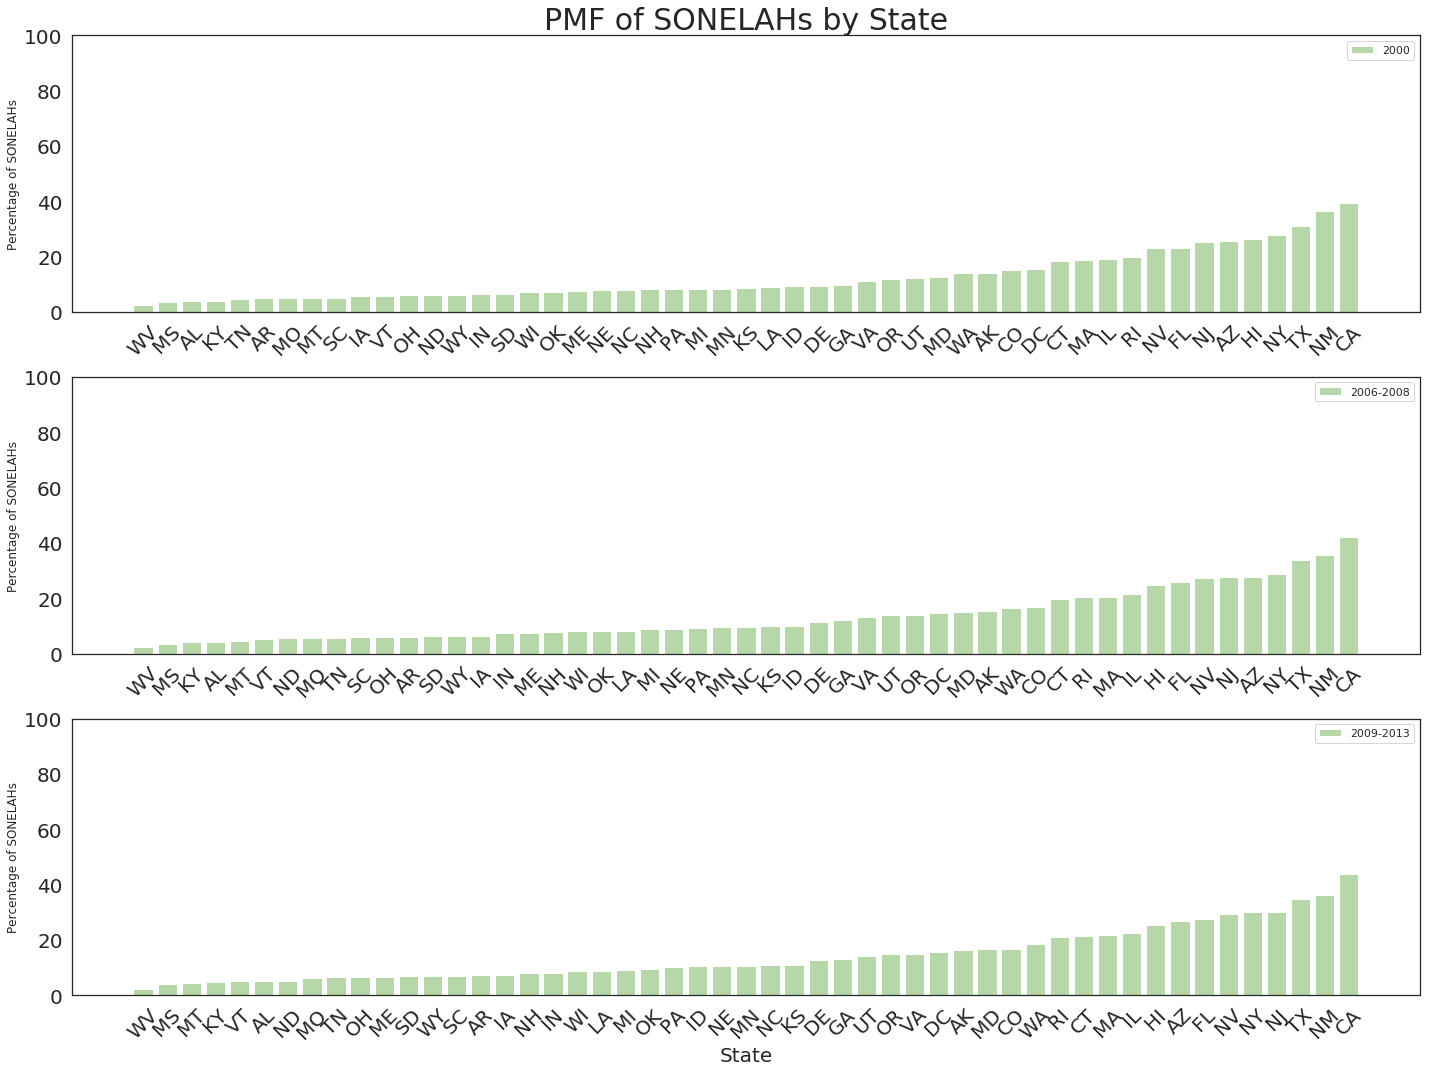

In [32]:

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,15), sharey=True)  # 1 row, 2 columns
plotPMFs(df2000, ax=ax1)
plotPMFs(df2006, ax=ax2)
plotPMFs(df2009, ax=ax3)
ax1.set_title('PMF of SONELAHs by State', fontsize=30)
ax3.set_xlabel('State', fontsize=20)
ax1.legend(['2000'])
ax2.legend(['2006-2008'])
ax3.legend(['2009-2013'])
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout() 

We see that throughout these three time periods, the shape of distribution and the magnitude of the percentages are relatively the same. We do see that, like in the tables, the order of the distribution changes only slightly. Even for the middle states, the rank usually does not change by more than three places.
</p>
States with large cities, coastal states and Southwestern states have more SONELAHs. This makes sense because Southwestern states were part of a region of Mexico, and have Latin heritage. Also, coastal states and states with large cities are attractive places for immigrants to live, because of the resources and the ease by which a person could get to them. States which have a low number of SONELAHs exhibit the opposite traits : they are hard to reach and do not have a large industry.

## County-Wide Analysis

From analyzing linguistic diversity at the state level, we wanted to explore states with very high and very low percentages of SONELAHs more closely. We did this to test whether states which have high percentages of SONELAHs have spread out or concentrated linguistic diversity. We also wanted to see if this same fluctuation over time we saw in the state level applied to the county level. 

##### Functions
First, we will create functions which will help us analyze and graph the data.

In [33]:
def createCountyNames(state):
    """
    Takes in a state. Returns a list of 
    counties in that state in the 2009-2013 period without the state abbreviation attached to it    
    
    state - state given ["stateabbreviation"], ie "CA"
    """
    countyNames = pd.Series()
    i=0
    x1 = pd.ExcelFile("./raw_data/LanguageSpokenatHome_County_2009-2013.xls")
    sheetnames = x1.sheet_names
    for sheet in sheetnames:
        if any(x in sheet for x in state):
            df = pd.read_excel("./raw_data/LanguageSpokenatHome_County_2009-2013.xls",sheet, skiprows=[0,1,2,3]).dropna()
            countyNames.set_value(i, sheet[:len(sheet)-4])
            i+=1
    return countyNames

In [34]:
def createStateDataFrame2000(state):
    """
    Takes in a state and returns a dataframe containing the counties and the 
    number of SONELAHs and EOS per county from 2000
    
    state - state given "stateabbreviation", ie "CA"
    """
    counties = createCountyNames([state])#list of counties
    lang=["English Only","SONELAHs","SPANISH AND SPANISH CREOLE",'German, Scandinavian, Italian',"ASIAN AND PACIFIC ISLAND LANGUAGES",'Native North American']
    df=pd.DataFrame(index=lang,columns=counties)
    parsetest =  pd.read_excel("./raw_data/LanguageSpokenatHome_2000.xlsx", state, skiprows=[0,1,2,3]).dropna()
    for county in counties: 
        eng=parsetest[(parsetest["Area Name (State or County)"]==county)& (parsetest["Census Tract Code"]==0) & (parsetest["Language Code"]==0)]
        sonnie=parsetest[(parsetest["Area Name (State or County)"]==county)& (parsetest["Census Tract Code"]==0) &(parsetest["Language Code"]!=0)]
        esp=parsetest[(parsetest["Area Name (State or County)"]==county) & (parsetest["Census Tract Code"]==0) &((parsetest["Language Code"]==627) | (parsetest["Language Code"]==625) | (parsetest["Language Code"]==628))]
        europe=parsetest[(parsetest["Area Name (State or County)"]==county) & (parsetest["Census Tract Code"]==0) &((parsetest["Language Code"]==607) | (parsetest["Language Code"]>=614) & (parsetest["Language Code"]<=619))]
        asian=parsetest[(parsetest["Area Name (State or County)"]==county) & (parsetest["Census Tract Code"]==0) &((parsetest["Language Code"]<=695) & (parsetest["Language Code"]>=684) | (parsetest["Language Code"]<=771) & (parsetest["Language Code"]>=698))]
        native=parsetest[(parsetest["Area Name (State or County)"]==county) & (parsetest["Census Tract Code"]==0) &((parsetest["Language Code"]<=955) & (parsetest["Language Code"]>=800) | (parsetest["Language Code"]<=966) & (parsetest["Language Code"]>=959)| (parsetest["Language Code"]<=982) & (parsetest["Language Code"]>=977))]
        langArray=[sum(eng["Number of speakers"]),sum(sonnie["Number of speakers"]),sum(esp["Number of speakers"]),sum(europe["Number of speakers"]),sum(asian["Number of speakers"]),sum(native["Number of speakers"])]
        df[county]=langArray
    df=df.T
    df=df.set_index(pd.Index(range(0,len(counties))))
    df=df.rename(columns={0:"English Speakers",1:"SONELAHs"})
    df["County"]= counties
    return df

This function takes in a given state, an empty list for counties and an empty list for SONELAHs per county. It returns the information about the desired state's counties and SONELAHs in them into the empty lists.

In [35]:
def createStateDataFrame2009(state):
    """
    Takes a state and returns the counties and the number of SONELAHS per county in the 2009-2013 period. 
    
    Takes:
    state - state you wish to look at, given as ex: ["AZ"]
    
    Returns:
    df - contains counties, number of EOS per county and number of SONELAHs per county

    """
    countyList = pd.Series()
    SONELAHNumbers = pd.Series()
    EOSNumbers = pd.Series()
    i=0
    x1 = pd.ExcelFile("./raw_data/LanguageSpokenatHome_County_2009-2013.xls")
    sheetnames = x1.sheet_names #Extract the County Names from the Excel Sheet Names
    for sheet in sheetnames:
        if any(x in sheet for x in state):
            df = pd.read_excel("./raw_data/LanguageSpokenatHome_County_2009-2013.xls",sheet, skiprows=[0,1,2,3]).dropna()
            SONELAHNumbers.set_value(i,df["Number of speakers1"][2]) #Append to list of SONELAHS per county from the desired state
            countyList.set_value(i, sheet) #Append to list of counties from the desired state
            EOSNumbers.set_value(i,df["Number of speakers1"][1]) #Append to list of EOS per county from the desired state
            i+=1
    df = pd.DataFrame({"County":countyList, "SONELAHs":SONELAHNumbers, "EOS": EOSNumbers})
    return df

The two functions below will allow us to plot the number of SONELAHs in each county as well as the percentage of SONELAHs in each county

In [36]:
def plotCounty(state):
    """
    Takes in the name of a state. The function will find the value of
    SONELAHS for the state in the 2000's and and the two Dataframes  
    which createCountySeries filled
    Plots the number of of SONELAHs by county
    
    state - the state you wish to look at, given as ex: "AZ"
    """
    dft1= createStateDataFrame2000(state)
    dft1=dft1.sort_values(by="SONELAHs")

    dft2=createStateDataFrame2009([state])
    dft2=dft2.sort_values(by="SONELAHs")

    ax=plt.subplot(111)
    i=0
    for SONELAH1,SONELAH2 in zip(dft1["SONELAHs"],dft2["SONELAHs"]): 
        ax.bar(i-0.2,SONELAH1,width=0.4,color='b',align='center')
        ax.bar(i+0.2,SONELAH2,width=0.4,color='g',align='center')
        plt.autoscale(enable=True)
        plt.xticks(range(0,len(dft1)), dft1["County"],  rotation=90)
        plt.title("SONELAHs in "+str(state)+" by County")
        plt.xlabel("County")
        plt.ylabel("Number of SONELAHs")
        i+=1
        ax.legend(["2000","2009-2013"])

In [44]:
def plotCountyPMF(statename):
    """
    Takes in the name of a state
    Plots the PMF of SONELAHs of certain language groups by county for 2000 and 2009-2013.
    
    state - given as ie "AK"
    """
    dft1=createStateDataFrame2000(statename)
    dft1["norm"] = (dft1["SONELAHs"]/(dft1["English Only"] + dft1["SONELAHs"]))*100
    dft1=dft1.sort_values(by="norm")
    dft2=createStateDataFrame2009([statename])
    dft2["norm"] = (dft2["SONELAHs"]/(dft2["EOS"] + dft2["SONELAHs"]))*100
    dft2=dft2.sort_values(by="norm")
    ax=plt.subplot(111)# Determines size of plot
    i=0
    for thing1,thing2 in zip(dft1["norm"],dft2["norm"]): 
        ax.bar(i-0.2,thing1,width=0.4,color='b',align='center')
        ax.bar(i+0.2,thing2,width=0.4,color='g',align='center')
        plt.autoscale(enable=True)
        plt.xticks(range(0,len(dft1)), dft1["County"],  rotation=90)
        plt.title("SONELAHs in "+str(statename)+" by County")
        plt.xlabel("County")
        plt.ylabel("PMF of Other Language Speakers")
        i+=1
        ax.legend(["2000","2009-2013"])

These last 3 functions allow us to plot a stacked bar graph of the different languages that appear in each county

In [45]:
def createCountiesList(state):
    """
    Creates a list of counties from the 2009-2013 counties list, when you input a state you want to analyze
    
    state - given as ex "CA"
    """
    textfileName =  "./raw_data/LanguageSpokenatHome_County_2009-2013.xls"
    countyNames = []
    x1 = pd.ExcelFile(textfileName)
    sheetnames = x1.sheet_names                        
    for sheet in sheetnames:
        if any(x in sheet for x in state):
            
            countyNames.append(str(sheet))

    return countyNames

In [39]:
def createListofLanguageGroupsCounties(state):
    """
    Takes in state  and returns dataframe which contains language groups and corresponding 
    number of respondents who speak a language in that language group
    
    state - given as "CA"
    """
    #Reading Excel spreadsheet
    textfileName =  "./raw_data/LanguageSpokenatHome_County_2009-2013.xls"
    #Initializing languages which we are looking for
    languagegroupstolookfor = ["SPANISH AND SPANISH CREOLE", ".Italian","..German", ".Scandinavian languages","..Pennsylvania Dutch",
                                 "ASIAN AND PACIFIC ISLAND LANGUAGES",".Navajo", ".Other Native North American languages"]
    #Initializing counties list 
    countyNames = createCountiesList(state)
    #Create emtpy dataframe
    languagesperState = pd.DataFrame(np.nan, index= np.array(countyNames), columns=np.array(languagegroupstolookfor)) #row index will be language and column index will be column index
    #Looping through the sheets and if the language and county are there, add it
    x1 = pd.ExcelFile(textfileName)
    sheetnames = x1.sheet_names
    for sheet in sheetnames:

        if sheet in countyNames:

            df = pd.read_excel(textfileName, sheet, skiprows=[0,1,2,3]).dropna()
            
            for language in languagegroupstolookfor:
                try:
                    num = df[df['Unnamed: 0']==language]["Number of speakers1"].item()/(df["Number of speakers1"][1]+df["Number of speakers1"][0])#select row from langauges column which has certain language
                    
                except:
                    num = 0
                
                languagesperState.loc[sheet, language] = num
                
     #Putting Some Languages into Categories and Deleting the Individual Ones
    languagesperState['German, Scandinavian, Italian'] = languagesperState.iloc[:, 1:5].sum(axis=1)
    languagesperState['Native North American'] = languagesperState.iloc[:, 6:8].sum(axis=1)
    languagesperState.drop([".Italian","..German", ".Scandinavian languages",".Navajo", ".Other Native North American languages","..Pennsylvania Dutch"], axis = 1, inplace = True) 
 

    return languagesperState

In [51]:
def plotLanguagesinCounties(state):
    """
    Takes in a state and returns a graph that has counties as the x-axis
    and bars representing the percentage of total people in the 
    desired state that speak one of four language groups
    
    state - your desired state, given as for example: "CA"
    """
    countylist = createCountiesList([state]) #initialize counties
    df= createListofLanguageGroupsCounties([state]) #create dataframe for state
    plt.figure(figsize=(20, 4))
    
    for i in range(0,len(df)):
        p1=df["SPANISH AND SPANISH CREOLE"][i]*100 #calling the number of spanish speakers in each county
        p2=df["German, Scandinavian, Italian"][i]*100
        p3=df["ASIAN AND PACIFIC ISLAND LANGUAGES"][i]*100
        p4=df["Native North American"][i]
        plt.bar(i, p1,color='g') #creating a bar graph that stacks bars
        plt.bar(i, p2,bottom=p1,color='b')
        plt.bar(i, p3,bottom=p1+p2,color='r')
        plt.bar(i, p4,bottom=p1+p2+p3,color='#800080')
        plt.autoscale(enable=True)
        plt.xticks(range(0,len(countylist)),countylist,rotation=90)
        plt.title("PMF of Language Speakers in "+str(state))
        plt.xlabel("County")
        plt.ylabel("Percentage of Speakers")
        plt.legend(['Spanish', 'Germanic, Italian & Scandinavian', 'Asian & Pacific Island Languages' , 'Native North American'])

##### California

Because California has been first on our three tables of states with the highest percentage of SONELAHs, we wanted to delve deeper into California's counties. We wanted to see if California's linguistic diversity is coming from one place, or if it's spread out. We also wanted to find out what percentage of SONELAHs in California are Spanish speakers.

First, we will plot the SONELAHs by county over the two time periods we have, to see how the distribution of SONELAHs varies by county, without taking into consideration the percentage.

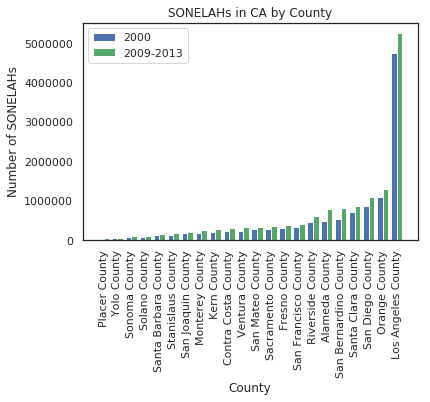

In [41]:
plotCounty("CA")

Clearly, Los Angeles has the largest number of SONELAHs by far. However, Los Angeles is a substantially large city. We suspect that the large number of SONELAHs in Los Angeles is due to the large population of Los Angeles in general. To test this, we will plot the percentages of SONELAHs per county.

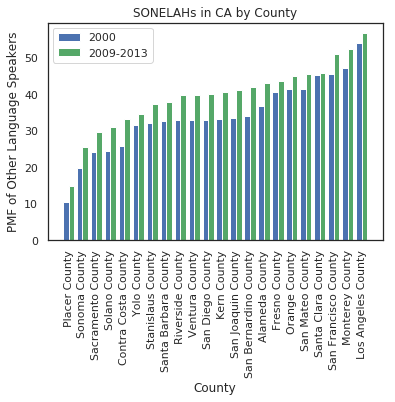

In [46]:
plotCountyPMF("CA")

Now, this graph tells us that the large difference between SONELAHs in Los Angeles and the rest of California is due to Los Angeles population. In terms of percentages of SONELAHs, California is more evenly distributed.
</p>
This graph also shows us that while the difference in percentage of SONELAHs is not as drastic, there is not an equal distribution. Los Angeles has the most SONELAHs, at more than 50 % of the population, while Placer County has only about 10 % of its population consist of SONELAHs. 
</p>
It is also interesting to note that over the 13 year period the percentage of SONELAHs for any county did not raise more than 5 percent. The percentage of SONELAHs is not rising very quickly even in a highly trafficked and populous state like California, which shows that the increasing number of SONELahs may feel rapid, but is in fact happening at a relatively slow pace.

Who are these SONELAHs, though? Because California was once part of Mexico and has Latin heritage, we suspect that a large percentage of SONELAHs in California are Spanish speakers. We also suspect that a substantial percentage of SONELAHs in California speak an Asian language, because of the west coast's proximity to Asia as well as California's history of immigration from Asia.
</p>
We are going to put that suspicion to the test by graphing different language speaking SONELAHs per county in California. We chose four language groups: 'Spanish and Creole', 'German, Italian and Scandinavian', 'Asian and Pacific Island Languages' and 'Native North American Languages'. 

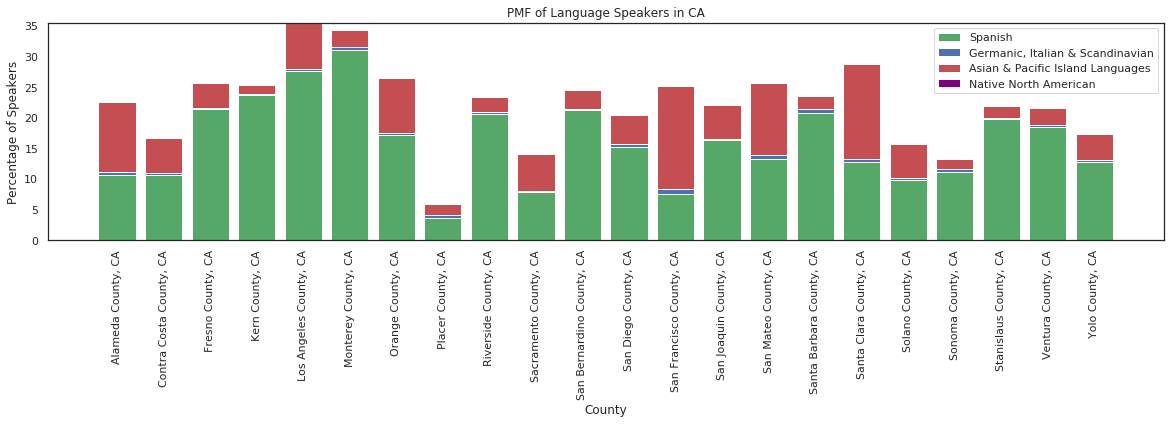

In [52]:
plotLanguagesinCounties("CA")

This graph shows what we were expecting: there is a large portion of SONELAHs in California who are Spanish speakers. There are also a significant amount of Asian and Pacific Island language speakers. 
</p>
<br>
Native North American languages are almost not represented at all in this graph. The Native American population in the United States is small, and we believe that a significant Native North American SONELAH population will only be found in a handful of counties spread across the Southwest. 
</p>
<br>

We were surprised that in San Francisco county and in Santa Clara county, the majority of SONELAHs speak an Asian or Pacific Island language. Doing a Google search on Asian immigration to San Francisco yields a first result of a Wikipedia article on History of Chinese Americans in San Francisco. San Francisco in fact "has the highest percentage of residents of Chinese descent of any major U.S. city, and the second largest Chinese American population, after New York City". [see Wikipedia article](https://en.wikipedia.org/wiki/History_of_Chinese_Americans_in_San_Francisco)
</p>
<br>

We also noticed that in Kenn, Stanislaus, Sonoma and Monterey counties, the majority of the SONELAHs language groups that we plotted were Spanish speaking. It was interesting to see that these counties are in Central and Southern California, but none of them are bordering or particularly close to Mexico. As previously stated, Mexico had owned a large part of southwestern America, including California, which could explain why these counties contain a high number of Spanish speakers. However, we still believe that it would be beneficial to look at other socioeconomic data to explain why these counties have such a high percentage of Spanish speaking SONELAHs, out of the language groups we tested for. 

From analyzing California's SONELAHs, we verified some notions that we had initially. We believe that it makes sense that there are more SONELAHs by number in large cities, but not by percentage. We did see outliers which had large and small percentages of SONELAHs (Los Angeles and Placer counties), but in the case of Los Angeles, we believe that this city has an abnormally high percentage of SONELAHs compared to the rest of the United States. We believe this because California has the highest percentage of SONELAHs on the state scale and Los Angeles is the county in California with the highest percentage of SONELAHs.
</p>
In terms of linguistic diversity being spread out, we did see concentrations of some language groups by county. Again, however, we believe that at least San Francisco is an outlier on the U.S. scale. We believe this because San Francisco has the second largest Chinese American population in the U.S.  

##### Pennsylvania

California consistently has the highest percentage of SONELAHs in the U.S.. What does a state which has a low percentage of SONELAHs look like? Is the linguistic diversity more spread out or concentrated? 

Let us see if SONELAHs are spread out, or if in Pennsylvania, like in California, there are more SONELAHs in urban areas.

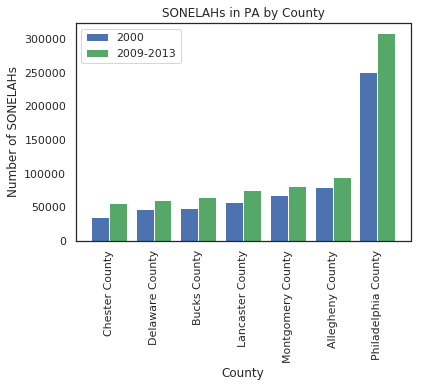

In [48]:
plotCounty("PA")

Philadephia county, which contains the city of Philadelphia, has the largest number of SONELAHs by number. In fact, it has more than twice the number of SONELAHs in any other county. This tells us that even in a state with a smaller percentage of SONELAHs and smaller major cities, there will be more SONELAHs in urban centers.


Will the percentage of SONELAHs be more equal between counties?

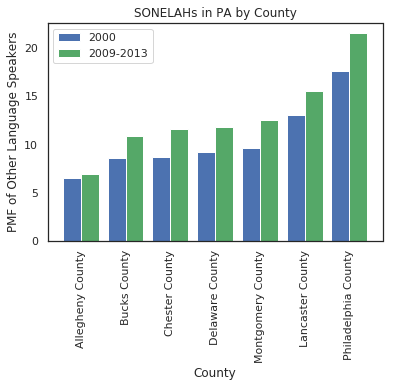

In [49]:
plotCountyPMF("PA")

The difference between the smallest and largest percentages of SONELAHs by county is about 15%, which is half the difference between the smallest and largest percentages of SONELAHs by county in California. Therefore, we think that linguistic diversity might be more spread out in Pennsylvania. This could also be an artifact of the state being smaller, so there are less opportunities for the percentages to deviate. Similarly to California, the difference in the percentage of SONELAHs between 2000 and 2009-2013 is about five percent, which is a very small amount of growth. The counties within states seem to have very little growth rates for SONELAHs regardless of how many live within the area.

In these counties, what does the spread of languages look like? We are expecting there to be a large Germanic percentage of SONELAHs because there is a large Dutch and Amish population in Pennsylvania. In fact, there exists a whole language named Pennsylvania Dutch. We included this language under our Germanic languages group.

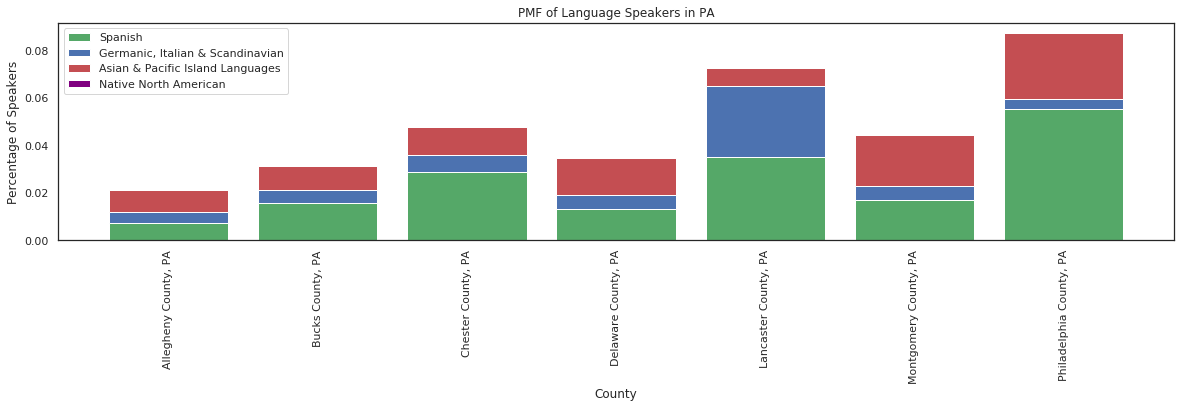

In [50]:
plotLanguagesinCounties("PA")

Lancaster county, which is known for being a Pennsylvania Dutch county, has the highest percentage of Germanic, Italian and Scandinavian languages that we have seen so far. However, for being a county known for having a population speak a language, the percentage of people who speak that language seems low to us. About 4% of Lancaster county speaks a Germanic, Italian or Scandinavian language. This means that by spending a day in Lancaster county, a person would likely not meet a Pennsylvania Dutch speaker. If we had the data, we would like to probe this distribution even further. For instance, due to Amish village attractions, we suspect that inside Lancaster county, there are concentrated groups of Pennsylvania Dutch speakers. 

</p>
</b>

Besides that, there is a consistently small percentage of those European languages in Pennsylvania. Again, there also is a minuscule population of Native North American languages. On the other hand, Spanish speakers are still the most prevalent kind of SONELAH within most of the counties. This may be caused by the fact that Spanish is the second most popular language in the U.S., or that the U.S. is physically connected to a large number of Spanish speaking countries, which makes immigration from those places more likely. Either way, the prevalence of Spanish speakers is clear.

</p>
</b>

After analyzing Pennsylvania, we can make more concrete conclusions about the trends we saw in California. SONELAHs tend to conglomerate in urban centers, which has been a noted trend for a large part of American history. In this way, our   data reflects known trends. Furthermore, in both states, we found that the number of SONELAHs in each county has increased only slightly in terms of both percentage and raw number. 
</p>
</b>

We had expected California, due to its geographic location, to have a high percentage of Spanish speakers. Pennsylvania, which is situated in the Northeast, also has Spanish speakers as its largest SONELAH group. The difference between these two states is that the ratio of Spanish speakers to other SONELAHs is not as high.

### Conclusions

In this experiment we wanted to answer 3 questions:"Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? Are regions with high ratios of non-English speakers actually linguistically diverse or homogeneously consisting of one non-English speaking community?". We have explored changes in the number of SONELAHs in both states and counties in order to examine the growth of their populations and the distribution of differing languages.

We have found that the number of SONELAHS has not increased what we would call a large amount. As seen by the table of top ten most diverse states for each of the three time frames, the most diverse states have only shifted by a few ranks. Even among states like New Jersey, that moved from 7th place in 2000 to 4th place in 2013, the percentage of SONELAHs had only increased about 5 percent over that time period. A person living in New Jersey would not notice a 5% change in population of SONELAHs around them, therefore we would not say that the population of SONELAHs has increased at rapid rates, like Tucker Carlson suggested. 

To answer if this trend also holds on a smaller level, we turn our attention to the individual counties. Within these states, we can see that the number of SONELAHs has increased a significant amount in some counties while only increasing slightly in others. After computing the percentage of SONELAHs within these states, we found that the percentage of SONELAHs had only increased slightly within any given county. So, the increasing number of SONELAHs seems to be a factor of population growth than an increase of immigrants.

The second question is somewhat more complicated. Linguistically diverse populations are definitely centered in certain areas, but they are not especially surprising. The southwestern states have a large number of SONELAHs within them, which is not especially surprising if it is taken into account that it was previously owned by Mexico. This trend can also be seen in the result that almost every county in California has a very large number of Spanish speakers, regardless of their proximity to Mexico. Most of the other states in the top ten table have large urban centers which have a history of attracting a greater number of immigrants. The same behavior is seen in the county breakdowns of the individual states. Urban centers like Los Angeles and Philadelphia have the highest number of SONELAHs within their respective states. Therefore, we believe that cultural diversity is not evenly distributed throughout the United States, but the spread is logical. We do not have specific enough data to refute Tucker Carlson's comment that immigration isn't occurring in the neighborhoods of politicians. We can say that unless a politician lives in a rural state like West Virginia, a politician is living close to where immigration is happening, because the number of SONELAHs in increasing almost everywhere.

In the third question we try to address how homogeneous the SONELAH populations are. We have found that Spanish is always largely represented in the states and counties we have analyzed. Although it is not the most represented language within a county, it is usually the first or second most represented language within a state. However, there are many counties where Spanish is not the majority, or it only has a very slight majority over another language. Because of this, we have come to the conclusion that we are unable to accurately predict exactly how homogeneous an area is. There are a multitude of factors that could contribute to there being a large majority of some given language in a particular county, and we do not have the data to confirm or predict what language is spoken most.

We do believe that the United States is becoming more diverse, but we do not believe it is happening at a very fast pace nor is it particularly focused in a single place. The growth of the number of SONELAHs is not extreme, but we have looked at data at a very large scale that may not be representative of how people interact with others in their day to day lives. We also acknowledge that this data is not extensive nor an extremely accurate representation of linguistic or cultural diversity in the United States. Like we mentioned before, this data does not take into consideration undocumented immigrants, who would change the percentages- but we do not know by how much. Furthermore, linguistic diversity is not always a good indicator of cultural diversity. For example, Spanish speakers represent a plethora of different cultures. Also, there are cultures, like some Native American cultures, which are dying out, and while there are people who identify with these cultures, the knowledge of the languages associated with them are being lost. 

After analyzing this data, we believe that the reason people believe the cultural diversity of America is changing so quickly is because we are more likely to notice people who do not fit into our expectation of who we will see in our neighborhoods and counties.